In [6]:
import h5py

import numpy as np

from matplotlib import pyplot as plt
from robomimic.utils.file_utils import get_demos_for_filter_key
# from examples.simple_train_loop import get_data_loader

In [7]:
f = h5py.File('datasets/lift/ph/low_dim_v141.hdf5', 'r')


In [8]:
f['mask'].keys()

<KeysViewHDF5 ['20_percent', '20_percent_train', '20_percent_valid', '50_percent', '50_percent_train', '50_percent_valid', 'train', 'valid']>

In [9]:
key_lst = get_demos_for_filter_key('datasets/lift/ph/low_dim_v141_att_mask_included.hdf5', 'high_att_train')

In [10]:
print(key_lst)

['demo_178', 'demo_70', 'demo_144', 'demo_45', 'demo_15', 'demo_188', 'demo_121', 'demo_54', 'demo_56', 'demo_134', 'demo_80', 'demo_171', 'demo_67', 'demo_41', 'demo_0', 'demo_68', 'demo_99', 'demo_11', 'demo_189', 'demo_131', 'demo_187', 'demo_12', 'demo_59', 'demo_182', 'demo_140', 'demo_63', 'demo_130', 'demo_43', 'demo_90', 'demo_185', 'demo_199', 'demo_101', 'demo_69', 'demo_157', 'demo_53', 'demo_161', 'demo_3', 'demo_112', 'demo_94', 'demo_142', 'demo_108', 'demo_7', 'demo_85', 'demo_190', 'demo_57', 'demo_139', 'demo_87', 'demo_110', 'demo_50', 'demo_82', 'demo_135', 'demo_91', 'demo_133', 'demo_76', 'demo_71', 'demo_89', 'demo_78', 'demo_86', 'demo_113', 'demo_58', 'demo_147', 'demo_105', 'demo_162', 'demo_48', 'demo_164', 'demo_159', 'demo_195', 'demo_84', 'demo_88', 'demo_40', 'demo_51', 'demo_66', 'demo_64', 'demo_72', 'demo_60', 'demo_73', 'demo_109', 'demo_169', 'demo_125', 'demo_74', 'demo_193', 'demo_196', 'demo_165', 'demo_192', 'demo_155', 'demo_194', 'demo_75', 'dem

In [11]:
# print(flow['mask'].keys())
# print(f['mask']['train'])
# # print(f['data'].attrs['env_args'])

# for i in range(180):
#     print(f['mask']['train'][i])

# print(f"Helol")
# for i in range(20):
#     print(f['mask']['valid'][i])


In [12]:
def get_attention(action_trajectory, state_trajectory, alpha, dt=0.05):
    assert action_trajectory.shape[0] == state_trajectory.shape[0]

    temporal_attention = (np.linalg.norm(action_trajectory[:-1, :-1] - action_trajectory[1:, :-1], axis=1)/dt)**2
    

    spatial_attention = (np.linalg.norm(action_trajectory[:1] - action_trajectory[1:], axis=1)/np.linalg.norm(state_trajectory[:1] - state_trajectory[1:], axis=1))**2

    dxdt = np.sqrt(np.sum((state_trajectory[1:] - state_trajectory[:-1])**2, axis=1) + dt**2)
    
    attention = ((alpha * spatial_attention + (1-alpha) * temporal_attention) * dxdt).mean()
    return attention


def get_attention_lst(h5py_path, filter_key):
    key_lst = get_demos_for_filter_key(h5py_path, filter_key)
    f = h5py.File(h5py_path, 'r')
    attention_lst = []
    for key in key_lst:
        action_trajectory = f['data'][key].get('actions')[()]
        state_trajectory = f['data'][key].get('obs').get('object')[()]
        attention = get_attention(action_trajectory, state_trajectory, alpha=0.0)
        attention_lst.append(attention)

    attention_lst = np.array(attention_lst)

    return attention_lst

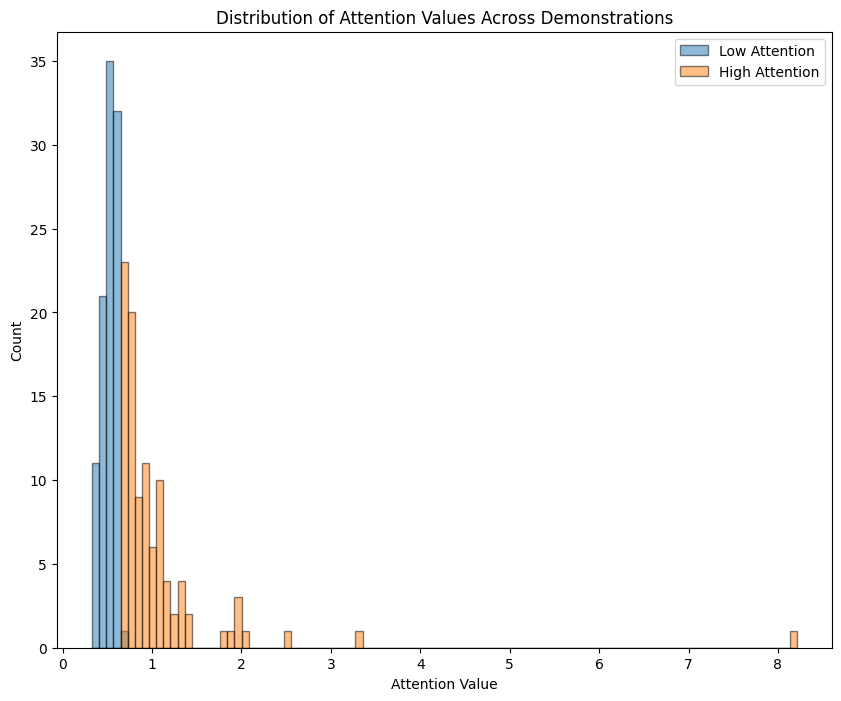

In [13]:
flow_attention_lst = get_attention_lst('datasets/lift/ph/low_dim_v141_att_mask_included.hdf5', 'low_att')
fhigh_attention_lst = get_attention_lst('datasets/lift/ph/low_dim_v141_att_mask_included.hdf5', 'high_att')

# Plot histogram of attention values for both low and high attention datasets
plt.figure(figsize=(10, 8))
bins = np.linspace(min(min(flow_attention_lst), min(fhigh_attention_lst)), 
                   max(max(flow_attention_lst), max(fhigh_attention_lst)), 
                   100)
plt.hist(flow_attention_lst, bins=bins, alpha=0.5, label='Low Attention', edgecolor='black')
plt.hist(fhigh_attention_lst, bins=bins, alpha=0.5, label='High Attention', edgecolor='black') 
plt.xlabel('Attention Value')
plt.ylabel('Count')
plt.title('Distribution of Attention Values Across Demonstrations')
plt.legend()
plt.show()

In [15]:
print(f"high_attention_max: {max(fhigh_attention_lst)}")
print(f"flow_attention_min: {min(flow_attention_lst)}")

high_attention_max: 8.209634730575884
flow_attention_min: 0.3303824446986532


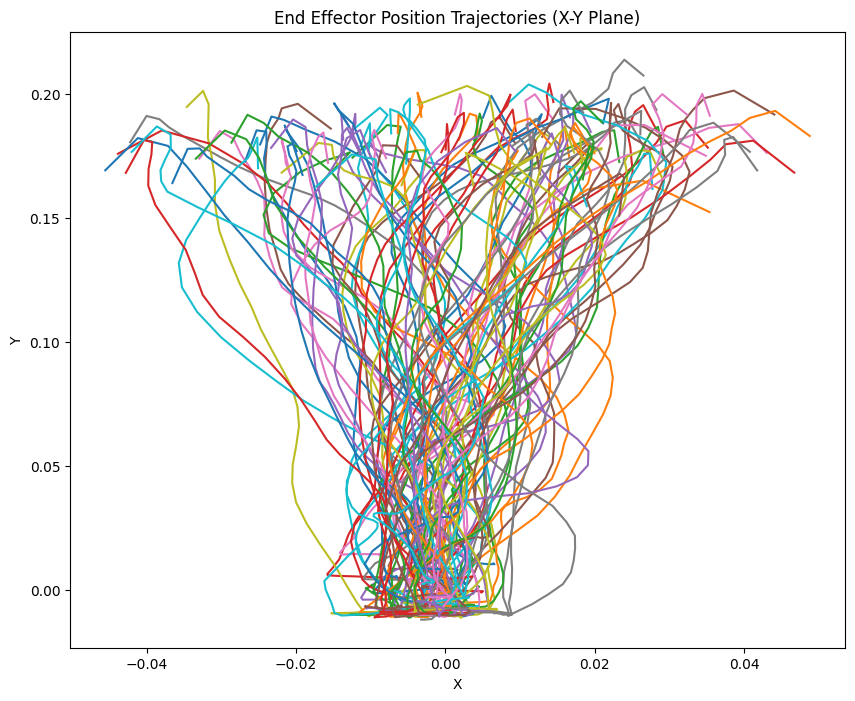

In [14]:
key_lst = get_demos_for_filter_key('datasets/lift/ph/low_dim_v141_att_mask_included.hdf5', 'high_att')
f = h5py.File('datasets/lift/ph/low_dim_v141_att_mask_included.hdf5', 'r')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

for key in key_lst:
    action_trajectory = f['data'][key].get('actions')[()]
    state_trajectory = f['data'][key].get('obs').get('object')[()]
    ax.plot(state_trajectory[:, -2], state_trajectory[:, -1], label=f'Demo {key}')

ax.set_xlabel('X')
ax.set_ylabel('Y')
# ax.legend()
ax.set_title('End Effector Position Trajectories (X-Y Plane)')

plt.show()


In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# Plot trajectories for 10 demonstrations with different colors
for i in [min_attention_idx, max_attention_idx]:
    object_state = f['data'][f'demo_{i}'].get('obs').get('object')[()]
    # print(object_state[0])
    ax.plot(object_state[:, -2], object_state[:, -1], label=f'Demo {i}')

# ax.scatter([0, 0], [0, 0], color='red', marker='*', s=200, label='Start')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.set_title('End Effector Position Trajectories (X-Y Plane)')

plt.show()

In [ ]:
max_action_trajectory = f['data'][f'demo_{max_attention_idx}'].get('actions')[()]
min_action_trajectory = f['data'][f'demo_{min_attention_idx}'].get('actions')[()]
fig = plt.figure(figsize=(10, 20))
plt.subplot(7, 1, 1)
plt.plot(min_action_trajectory[:, 0])
plt.plot(max_action_trajectory[:, 0])
plt.title('Action Trajectory - X Component')
plt.subplot(7, 1, 2) 
plt.plot(min_action_trajectory[:, 1])
plt.plot(max_action_trajectory[:, 1])
plt.title('Action Trajectory - Y Component')
plt.subplot(7, 1, 3)
plt.plot(min_action_trajectory[:, 2])
plt.plot(max_action_trajectory[:, 2])
plt.title('Action Trajectory - Z Component')
plt.subplot(7, 1, 4)
plt.plot(min_action_trajectory[:, 3])
plt.plot(max_action_trajectory[:, 3])
plt.title('Action Trajectory - Quaternion W Component')
plt.subplot(7, 1, 5)
plt.plot(min_action_trajectory[:, 4])
plt.plot(max_action_trajectory[:, 4])
plt.title('Action Trajectory - Quaternion X Component')
plt.subplot(7, 1, 6)
plt.plot(min_action_trajectory[:, 5])
plt.plot(max_action_trajectory[:, 5])
plt.title('Action Trajectory - Quaternion Y Component')
plt.subplot(7, 1, 7)
plt.plot(min_action_trajectory[:, 6])
plt.plot(max_action_trajectory[:, 6])
plt.title('Action Trajectory - Quaternion Z Component')
plt.show()




In [ ]:
# Sort episodes by attention values
attention_values = np.array([attention_lst[i] for i in range(len(attention_lst))])
sorted_indices = np.argsort(attention_values)
split_idx = len(sorted_indices) // 2

# Create new HDF5 files
with h5py.File('low_dim_v141_low_att.hdf5', 'w') as flow, \
     h5py.File('low_dim_v141_high_att.hdf5', 'w') as fhigh:
    
    # Create data groups
    flow.create_group('data')
    fhigh.create_group('data')
    
    # Create mask groups 
    flow.create_group('mask')
    fhigh.create_group('mask')
    
    # Copy episodes with lower attention values
    for idx in sorted_indices[:split_idx]:
        print(idx)
        demo_name = f'demo_{idx}'
        # Create demo group
        flow['data'].create_group(demo_name)
        # Copy data
        flow.copy(f['data'][demo_name], flow['data'][demo_name])
        # Copy corresponding mask if exists
        if demo_name in f['mask']:
            flow.copy(f['mask'][demo_name], flow['mask'][demo_name])
    
    # Copy episodes with higher attention values  
    for idx in sorted_indices[split_idx:]:
        print(idx)
        demo_name = f'demo_{idx}'
        # Create demo group
        fhigh['data'].create_group(demo_name)
        # Copy data
        fhigh.copy(f['data'][demo_name], fhigh['data'][demo_name])
        # Copy corresponding mask if exists
        if demo_name in f['mask']:
            fhigh.copy(f['mask'][demo_name], fhigh['mask'][demo_name])

print(f"Created low attention file with {len(sorted_indices[:split_idx])} episodes")
print(f"Created high attention file with {len(sorted_indices[split_idx:])} episodes")


In [ ]:
f['data']['demo_83']